# XGB high proba

The purpose of this notebook is to ensemble two XGB models: One is the "normal" XGB model trained on the top 10 columns, and another is a model trained specifically on data where this primary XGB model has a low predicted probability. Ensembling will then just compose switching from one model to the other depending on the predicted probability of the main model.

In [205]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.layers.experimental import preprocessing

## Data prep

In [126]:
df = pd.read_csv('../data/start_to_finish.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)

In [127]:
cols = ['home_win', 'Y', 'M', 'team_avg_pct_diff',
       'team_obp_pct_diff', 'team_slg_pct_diff', 'team_ERA_pct_diff',
       'team_WHIP_pct_diff', 'team_W-L_pct_diff', 'team_Rank_pct_diff',
       'team_FP_pct_diff', 'team_R_pct_diff', 'team_RA_pct_diff', 'team_pytha_pct_diff',
       'team_bayes_pct_diff', 'pitcher_WHIP_pct_diff',
       'pitcher_ERA_pct_diff', 'pitcher_IP_pct_diff', 'team_ops_pct_diff', 'log_5']

In [128]:
df = df[cols]

In [129]:
train_df = df[df['Y'] <= 2015]
test_df = df[df['Y'] > 2015]

X_train = train_df.drop('home_win', axis=1)
y_train = train_df['home_win'].astype(int)

X_test = test_df.drop('home_win', axis=1)
y_test = test_df['home_win'].astype(int)

In [130]:
def fill_na_inf(df):
    for c in df.columns:
        if df[c].isin([-np.inf, np.inf]).sum() > 0:
            df[c] = df[c].replace([-np.inf, np.inf], None)
        if df[c].isna().sum() > 0:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    return df

In [200]:
train_df = fill_na_inf(train_df)
test_df = fill_na_inf(test_df)

X_train = fill_na_inf(X_train)
X_test = fill_na_inf(X_test)

## Main XGB model

In [132]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

In [133]:
xgb_clf = xgb.XGBClassifier(**params)

In [134]:
xgb_clf.fit(X_train, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
xgb_preds = xgb_clf.predict(X_test)

test_acc = accuracy_score(y_test, xgb_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 62.20%


## Scaling probability

Adjust predicted probability to be between 0 and 1, with 0 meaning a predicted probability of 0.5, and 1 being either a predicted probability of 0 or 1 (in other words, complete confidence). Note that this is equivalent to simply finding the distance of the predicted probability from 0.5, and then multiplying to 2 (to get values between 0 and 1). We scale just for simplicity.

In [136]:
def adjust_proba(x):
    if x > 0.5:
        return 2*(x - 0.5)
    else:
        return 2*(1 - x - 0.5)

Get predicted probability on the _train_ set so that we know which rows to train the secondary model on.

In [137]:
xgb_train_preds = xgb_clf.predict(X_train)
xgb_train_proba_preds = xgb_clf.predict_proba(X_train)

adjust_proba = np.vectorize(adjust_proba)
xgb_train_proba_scaled = adjust_proba(xgb_train_proba_preds[:, 1])

train_df['xgb_main_proba_scaled'] = xgb_train_proba_scaled
train_df['xgb_main_pred'] = xgb_train_preds

<ipython-input-137-1c989006d3c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xgb_main_proba_scaled'] = xgb_train_proba_scaled
<ipython-input-137-1c989006d3c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xgb_main_pred'] = xgb_train_preds


## Accuracy by cutoff

Find the accuracy of the main model for each scaled probability cutoff.

In [138]:
cutoffs = np.linspace(0, 1, 100)
pct_correct_main = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = train_df[train_df['xgb_main_proba_scaled'] > c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_main_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_main[i] = acc

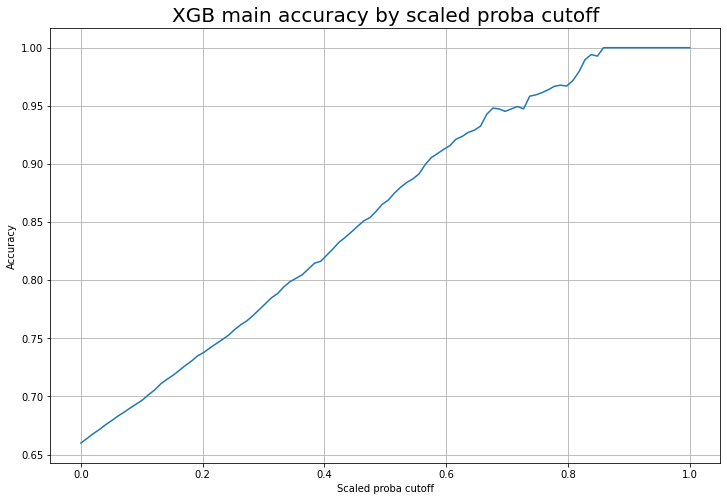

In [139]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_main)
plt.title('XGB main accuracy by scaled proba cutoff', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Accuracy')
plt.grid();

In [140]:
# Find the minimum cutoff needed to get a certain accuracy
def cutoff_by_acc(acc):
    cutoff = cutoffs[np.where(pct_correct_main>acc)[0][0]]
    return cutoff

For each cutoff, how many training rows are remaining (i.e. how many have a scaled predicted probability less than the cutoff)?

In [141]:
num_train_rows_remaining = [train_df[train_df['xgb_main_proba_scaled'] < c].shape[0] 
                            for c in cutoffs]

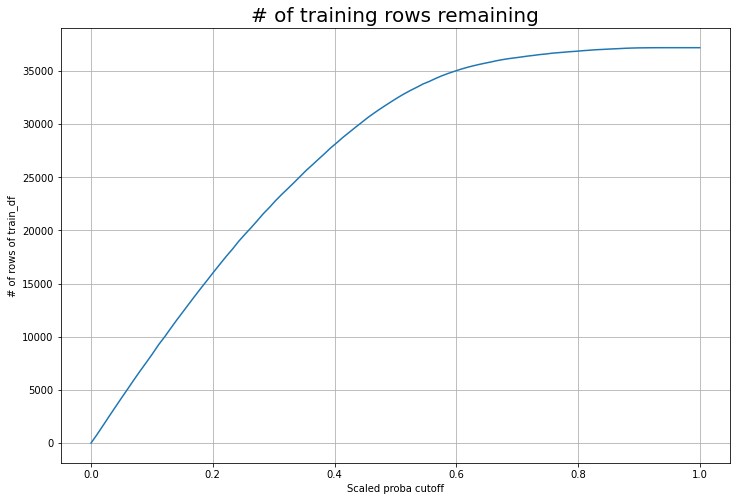

In [142]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, num_train_rows_remaining)
plt.title('# of training rows remaining', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('# of rows of train_df')
plt.grid();

Pick a cutoff just by looking at the above graphs and train an XGB model on the remaining training data. We don't want too small of a number of rows remaining, otherwise there won't be enough data to train on. But we don't want _too many_ rows remaining, otherwise the main model won't be contributing much. We'll start with a rough guess of what cutoff to pick, then we'll optimize later.

In [144]:
initial_cutoff = 0.2

train_low_proba_df = train_df[train_df['xgb_main_proba_scaled'] < initial_cutoff]

X_train_low_proba = train_low_proba_df.drop(['home_win', 'xgb_main_proba_scaled', 'xgb_main_pred'], axis=1)
y_train_low_proba = train_low_proba_df['home_win']

print(f'Training secondary model on {train_low_proba_df.shape[0]} rows')

Training secondary model on 15982 rows


Train the secondary model. Going forward we'll want to retune hyperparameters, but for now we'll just use what we used above.

In [147]:
xgb_secondary_clf = xgb.XGBClassifier(**params)
xgb_secondary_clf.fit(X_train_low_proba, y_train_low_proba)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Record preds and scaled probas

Record the predictions and scaled probabilities for both models.

In [148]:
# Main model
xgb_test_main_preds = xgb_clf.predict(X_test)
xgb_test_main_proba_preds = xgb_clf.predict_proba(X_test)
xgb_test_proba_scaled = adjust_proba(xgb_test_main_proba_preds[:, 1])

# Secondary model
xgb_test_secondary_preds = xgb_secondary_clf.predict(X_test)
xgb_test_secondary_proba_preds = xgb_secondary_clf.predict_proba(X_test)
xgb_test_secondary_proba_scaled = adjust_proba(xgb_test_secondary_proba_preds[:, 1])

test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled

test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
test_df['xgb_secondary_pred'] = xgb_test_secondary_preds.astype(int)

<ipython-input-148-8adff329016c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-148-8adff329016c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled
<ipython-input-148-8adff329016c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

Repeat for the training set for accuracy analysis (like the graph above).

In [149]:
# Main model
xgb_train_main_preds = xgb_clf.predict(X_train)
xgb_train_main_proba_preds = xgb_clf.predict_proba(X_train)
xgb_train_proba_scaled = adjust_proba(xgb_train_main_proba_preds[:, 1])

# Secondary model
xgb_train_secondary_preds = xgb_secondary_clf.predict(X_train)
xgb_train_secondary_proba_preds = xgb_secondary_clf.predict_proba(X_train)
xgb_train_secondary_proba_scaled = adjust_proba(xgb_train_secondary_proba_preds[:, 1])

train_df['xgb_main_proba_scaled'] = xgb_train_proba_scaled
train_df['xgb_secondary_proba_scaled'] = xgb_train_secondary_proba_scaled

train_df['xgb_main_pred'] = xgb_train_main_preds.astype(int)
train_df['xgb_secondary_pred'] = xgb_train_secondary_preds.astype(int)

<ipython-input-149-7ab4b3f956cf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xgb_main_proba_scaled'] = xgb_train_proba_scaled
<ipython-input-149-7ab4b3f956cf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['xgb_secondary_proba_scaled'] = xgb_train_secondary_proba_scaled
<ipython-input-149-7ab4b3f956cf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Accuracy of secondary model by cutoff

If we take the cutoffs applied to the main model (so all rows where the main model has a scaled probability less than the cutoff), how does the secondary model perform on only these rows?

In [150]:
cutoffs = np.linspace(0.01, 1, 100)
pct_correct_secondary = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = train_df[train_df['xgb_main_proba_scaled'] < c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_secondary_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_secondary[i] = acc

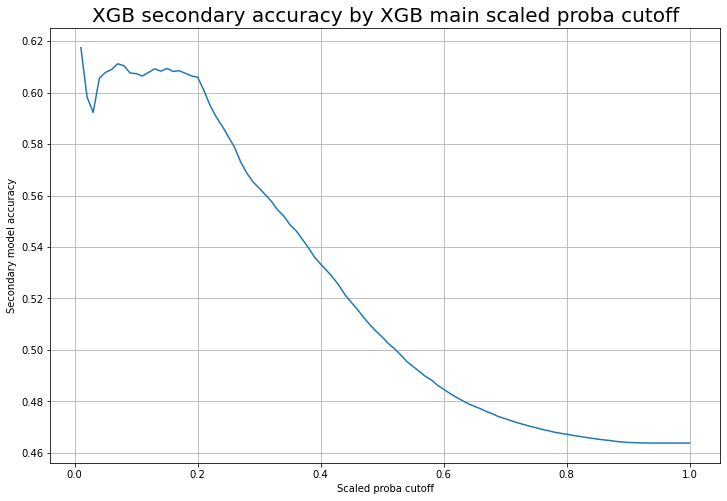

In [151]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_secondary)
plt.title('XGB secondary accuracy by XGB main scaled proba cutoff', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Secondary model accuracy')
plt.grid();

Let's plot both the secondary and main models together.

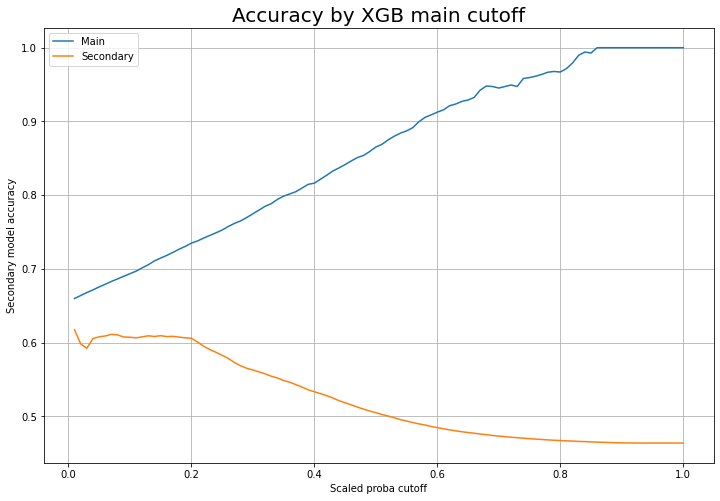

In [152]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_main, label='Main')
plt.plot(cutoffs, pct_correct_secondary, label='Secondary')
plt.title('Accuracy by XGB main cutoff', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Secondary model accuracy')
plt.grid()
plt.legend();

And finally, let's check out the accuracy of the secondary model if you use its own scaled probability cutoff.

In [175]:
cutoffs = np.linspace(0.01, 0.8, 100)
pct_correct_secondary_test = np.zeros_like(cutoffs)

for i, c in enumerate(cutoffs):
    sub_df = test_df[test_df['xgb_secondary_proba_scaled'] > c]
    if sub_df.shape[0] > 0:
        acc = sub_df[sub_df['xgb_secondary_pred'] == sub_df['home_win']].shape[0] / sub_df.shape[0]
    else:
        acc = 1
    pct_correct_secondary_test[i] = acc

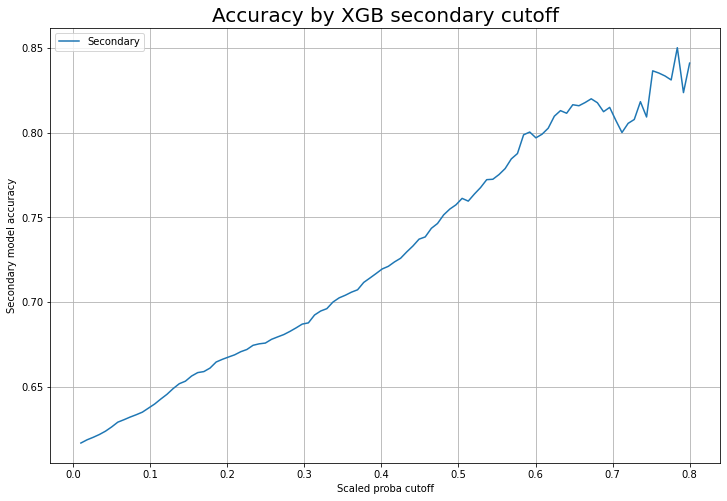

In [176]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, pct_correct_secondary_test, label='Secondary')
plt.title('Accuracy by XGB secondary cutoff', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Secondary model accuracy')
plt.grid()
plt.legend();

## Ensemble

Ensemble these two models according to the chosen cutoff. First we run the main model. If it's scaled predicted probability is less than the chosen cutoff, then switch to the secondary model. Otherwise, use the main model.

In [153]:
def ensembled_pred(row):
    if row['xgb_main_proba_scaled'] > initial_cutoff:
        return row['xgb_main_pred']
    else:
        return row['xgb_secondary_pred']

In [154]:
test_df['ensembled_pred'] = test_df.apply(ensembled_pred, axis=1).astype(int)

<ipython-input-154-5a012dd8a1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ensembled_pred'] = test_df.apply(ensembled_pred, axis=1).astype(int)


In [155]:
test_df.head()

,home_win,Y,M,team_avg_pct_diff,team_obp_pct_diff,team_slg_pct_diff,team_ERA_pct_diff,team_WHIP_pct_diff,team_W-L_pct_diff,team_Rank_pct_diff,...,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,team_ops_pct_diff,log_5,xgb_main_proba_scaled,xgb_secondary_proba_scaled,xgb_main_pred,xgb_secondary_pred,ensembled_pred
37193,1.0,2016,4.0,0.023097,0.003769,-0.040732,0.089783,-0.012113,-0.020408,0.50,...,-0.004934,0.021215,0.0,0.001479,0.5,0.086173,0.057829,1,1,1
37194,0.0,2016,4.0,-0.058646,-0.075552,-12.023378,-0.018717,0.014688,-0.162500,0.75,...,-0.004934,0.021215,0.0,-0.100639,0.5,0.157617,0.249818,0,0,0
37195,1.0,2016,4.0,0.086207,0.030927,2.578581,0.077540,0.080079,0.052632,0.00,...,-0.004934,0.021215,0.0,0.028053,0.5,0.023428,0.290403,0,0,0
37196,0.0,2016,4.0,0.007500,0.019876,4.000872,0.043269,-0.016226,-0.117647,0.20,...,-0.004934,0.021215,0.0,0.031095,0.5,0.092826,0.114938,1,0,0
37197,0.0,2016,4.0,0.003989,-0.049505,-0.794957,0.147208,0.089003,-0.141176,0.00,...,-0.004934,0.021215,0.0,-0.026164,0.5,0.083983,0.007170,0,1,1


In [156]:
accuracy_score(test_df['home_win'].astype(int), test_df['ensembled_pred'])

0.5902596095793923

Well crap.

Let's look into the accuracy of both models to see what's going on. We'll look at 

Let's wrap this all as a function and then loop through all possible cutoffs.

In [184]:
def ensemble_by_cutoff(cutoff):
    # Get the low probability rows
    train_low_proba_df = train_df[train_df['xgb_main_proba_scaled'] < cutoff]
    X_train_low_proba = train_low_proba_df.drop(['home_win', 'xgb_main_proba_scaled', 'xgb_main_pred', 'xgb_secondary_proba_scaled', 'xgb_secondary_pred'], axis=1)
    y_train_low_proba = train_low_proba_df['home_win']
    
    # Train the secondary model on them
    xgb_secondary_clf = xgb.XGBClassifier(**params)
    xgb_secondary_clf.fit(X_train_low_proba, y_train_low_proba)
    
    # Record predictions and probabilities
    # Main model
    xgb_test_main_preds = xgb_clf.predict(X_test)
    xgb_test_main_proba_preds = xgb_clf.predict_proba(X_test)
    xgb_test_proba_scaled = adjust_proba(xgb_test_main_proba_preds[:, 1])

    # Secondary model
    xgb_test_secondary_preds = xgb_secondary_clf.predict(X_test)
    xgb_test_secondary_proba_preds = xgb_secondary_clf.predict_proba(X_test)
    xgb_test_secondary_proba_scaled = adjust_proba(xgb_test_secondary_proba_preds[:, 1])

    test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
    test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled

    test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
    test_df['xgb_secondary_pred'] = xgb_test_secondary_preds.astype(int)
    
    # Get the low and high probability rows (for analysis)
    test_low_df = test_df[test_df['xgb_main_proba_scaled'] < cutoff]
    test_high_df = test_df[test_df['xgb_main_proba_scaled'] >= cutoff]
    
    # Main model accuracy on all rows
    main_all_acc = accuracy_score(test_df['home_win'], test_df['xgb_main_pred'])
    # Main model accuracy rows with proba >= cutoff
    main_high_acc = accuracy_score(test_high_df['home_win'], test_high_df['xgb_main_pred'])
    # Secondary model accuracy on all rows
    secondary_all_acc = accuracy_score(test_df['home_win'], test_df['xgb_secondary_pred'])
    # Secondary model accuracy rows with proba < cutoff
    secondary_low_acc = accuracy_score(test_low_df['home_win'], test_low_df['xgb_secondary_pred'])
    
    # Ensembling function
    def ensembled_pred(row):
        if row['xgb_main_proba_scaled'] > cutoff:
            return row['xgb_main_pred']
        else:
            return row['xgb_secondary_pred']
    
    # Ensemble
    test_df['ensembled_pred'] = test_df.apply(ensembled_pred, axis=1).astype(int)
    
    # Accuracy
    ensemble_acc = accuracy_score(test_df['home_win'].astype(int), test_df['ensembled_pred'])
    return ensemble_acc, main_all_acc, main_high_acc, secondary_all_acc, secondary_low_acc

In [185]:
cutoffs = np.linspace(0.01, 0.8, 20)
ensemble_accs = []
main_all_accs = []
main_high_accs = []
secondary_all_accs = []
secondary_low_accs = []

for c in cutoffs:
    ensemble_acc, main_all_acc, main_high_acc, secondary_all_acc, secondary_low_acc = ensemble_by_cutoff(c)
    ensemble_accs.append(ensemble_acc)
    main_all_accs.append(main_all_acc)
    main_high_accs.append(main_high_acc)
    secondary_all_accs.append(secondary_all_acc)
    secondary_low_accs.append(secondary_low_acc)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
<ipython-input-184-e7a6de66ef7f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-184-e7a6de66ef7f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

<ipython-input-184-e7a6de66ef7f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-184-e7a6de66ef7f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled
<ipython-input-184-e7a6de66ef7f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-184-e7a6de66ef7f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-184-e7a6de66ef7f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled
<ipython-input-184-e7a6de66ef7f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-184-e7a6de66ef7f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-184-e7a6de66ef7f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled
<ipython-input-184-e7a6de66ef7f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<ipython-input-184-e7a6de66ef7f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-184-e7a6de66ef7f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_secondary_proba_scaled'] = xgb_test_secondary_proba_scaled
<ipython-input-184-e7a6de66ef7f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

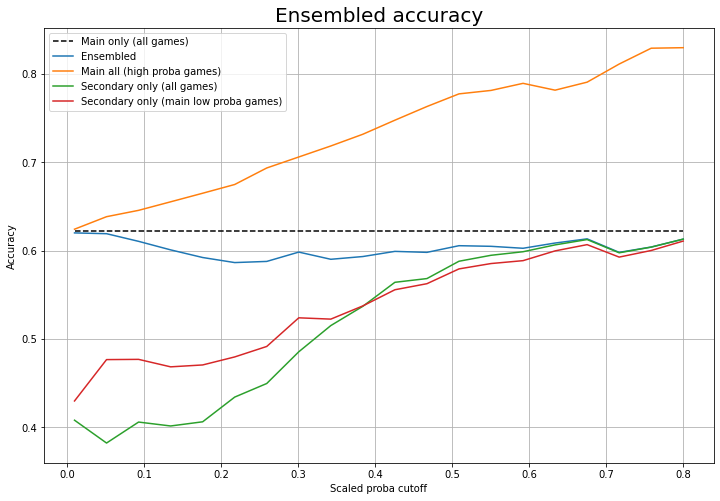

In [186]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, main_all_accs, label='Main only (all games)', linestyle='--', color='black')
plt.plot(cutoffs, ensemble_accs, label='Ensembled')
plt.plot(cutoffs, main_high_accs, label='Main all (high proba games)')
plt.plot(cutoffs, secondary_all_accs, label='Secondary only (all games)')
plt.plot(cutoffs, secondary_low_accs, label='Secondary only (main low proba games)')
plt.title('Ensembled accuracy', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();

## More model types

Finally, let's try both KNN and a NN on the low probability games to see if ensembling them works any better.

In [208]:
def knn_ensemble_by_cutoff(cutoff):
    # Get the low probability rows
    train_low_proba_df = train_df[train_df['xgb_main_proba_scaled'] < cutoff]
    cols_to_drop = ['home_win', 'xgb_main_proba_scaled', 'xgb_main_pred', 'xgb_secondary_proba_scaled', 'xgb_secondary_pred']
    cols_to_drop = list(set(train_df.columns).intersection(set(cols_to_drop)))
    X_train_low_proba = train_low_proba_df.drop(cols_to_drop, axis=1)
    y_train_low_proba = train_low_proba_df['home_win']
    
    # Train the secondary model on them
    ss = StandardScaler()
    ss.fit(pd.concat([X_train_low_proba, X_test]))
    X_train_scaled_low_proba = ss.transform(X_train_low_proba)
    X_test_scaled = ss.transform(X_test)
    knn_clf = KNeighborsClassifier(150)
    knn_clf.fit(X_train_scaled_low_proba, y_train_low_proba)
    
    # Record predictions and probabilities
    # Main model
    xgb_test_main_preds = xgb_clf.predict(X_test)
    xgb_test_main_proba_preds = xgb_clf.predict_proba(X_test)
    xgb_test_proba_scaled = adjust_proba(xgb_test_main_proba_preds[:, 1])

    # Secondary model
    knn_test_preds = knn_clf.predict(X_test_scaled)

    test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled

    test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
    test_df['xgb_secondary_pred'] = knn_test_preds.astype(int)
    
    # Get the low and high probability test rows (for analysis)
    test_low_df = test_df[test_df['xgb_main_proba_scaled'] < cutoff]
    test_high_df = test_df[test_df['xgb_main_proba_scaled'] >= cutoff]
    
    # Main model accuracy on all rows
    main_all_acc = accuracy_score(test_df['home_win'], test_df['xgb_main_pred'])
    # Main model accuracy rows with proba >= cutoff
    main_high_acc = accuracy_score(test_high_df['home_win'], test_high_df['xgb_main_pred'])
    # Secondary model accuracy on all rows
    secondary_all_acc = accuracy_score(test_df['home_win'], test_df['xgb_secondary_pred'])
   
    # Ensembling function
    def ensembled_pred(row):
        if row['xgb_main_proba_scaled'] > cutoff:
            return row['xgb_main_pred']
        else:
            return row['xgb_secondary_pred']
    
    # Ensemble
    test_df['ensembled_pred'] = test_df.apply(ensembled_pred, axis=1).astype(int)
    
    # Accuracy
    ensemble_acc = accuracy_score(test_df['home_win'].astype(int), test_df['ensembled_pred'])
    return ensemble_acc, main_all_acc, main_high_acc, secondary_all_acc

In [209]:
cutoffs = np.linspace(0.01, 0.8, 20)
ensemble_accs = []
main_all_accs = []
main_high_accs = []
secondary_all_accs = []

for c in cutoffs:
    ensemble_acc, main_all_acc, main_high_acc, secondary_all_acc = knn_ensemble_by_cutoff(c)
    ensemble_accs.append(ensemble_acc)
    main_all_accs.append(main_all_acc)
    main_high_accs.append(main_high_acc)
    secondary_all_accs.append(secondary_all_acc)

<ipython-input-208-0578a56f57ff>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-208-0578a56f57ff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
<ipython-input-208-0578a56f57ff>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-208-0578a56f57ff>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-208-0578a56f57ff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
<ipython-input-208-0578a56f57ff>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-208-0578a56f57ff>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-208-0578a56f57ff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
<ipython-input-208-0578a56f57ff>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-208-0578a56f57ff>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_proba_scaled'] = xgb_test_proba_scaled
<ipython-input-208-0578a56f57ff>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['xgb_main_pred'] = xgb_test_main_preds.astype(int)
<ipython-input-208-0578a56f57ff>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

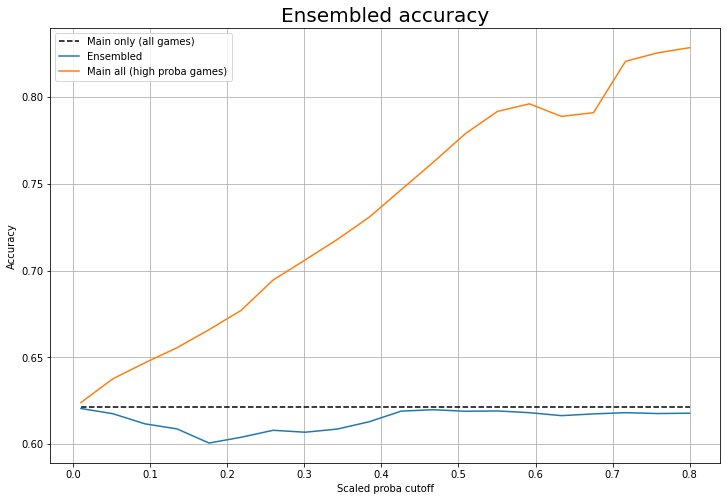

In [211]:
plt.figure(figsize=(12, 8))
plt.plot(cutoffs, main_all_accs, label='Main only (all games)', linestyle='--', color='black')
plt.plot(cutoffs, ensemble_accs, label='Ensembled')
plt.plot(cutoffs, main_high_accs, label='Main all (high proba games)')
# plt.plot(cutoffs, secondary_all_accs, label='Secondary only (all games)')
plt.title('Ensembled accuracy', fontsize=20)
plt.xlabel('Scaled proba cutoff')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();